In [8]:
import jax
import jax.numpy as jnp
import optax

In [9]:
def dynamics(x, u):
    """
    2D system dynamics with a goal-seeking component
    x and u are both 2D vectors
    """
    goal = jnp.array([2.5, 1.5])  # Goal position on the other side of the obstacle
    goal_attraction = 0.5 * (goal - x)  # Attraction to goal
    return goal_attraction + u  # Removed the -x term to create need for obstacle avoidance

In [10]:
def objective_function(u):
    """Objective function for control effort minimization"""
    return jnp.sum(u**2)

In [11]:
def cbf(x):
    """
    Barrier function for obstacle avoidance in 2D
    Returns a scalar value representing distance to obstacle minus radius
    """
    x_obs = jnp.array([2.0, 1.0])  # 2D obstacle position
    radius = 0.5
    return jnp.linalg.norm(x - x_obs) - radius


def cbf_constraint(x, u, alpha=1.0):
    """Barrier function constraint for 2D system"""
    h_x = cbf(x)
    dh_dx = jax.jacfwd(cbf)(x)

    f_x = dynamics(x, jnp.zeros(2))  # f(x) = dx/dt where u = 0
    
    # Take a derivative of x' = f(x) + g(x)u w.r.t. u
    g_x = jax.jacfwd(lambda u_: dynamics(x, u_))(x)
    
    # Lie derivatives
    lie_f = dh_dx @ f_x
    lie_g = dh_dx @ g_x @ u
    
    return lie_f + lie_g + alpha * h_x

In [14]:
def solve_cbf_qp(
    x0,
    learning_rate=0.01,
    num_iterations=2000,
    alpha=1.0,
):
    """Solves a Control Barrier Function (CBF) Quadratic Program (QP) for 2D system"""
    u_min, u_max = -10.0, 10.0

    @jax.jit
    def total_loss(u, x0):
        """Total loss function for CBF-QP"""
        constraint_val = -cbf_constraint(x0, u)
        constraint_violation = jnp.maximum(constraint_val, 0.0)  # Max(0, -h(x))
        return objective_function(u) + 1000.0 * jnp.sum(constraint_violation)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(total_loss)(params, x0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    optimizer = optax.adam(learning_rate)
    params = jnp.zeros(2)  # Initial 2D control input
    opt_state = optimizer.init(params)

    for i in range(num_iterations):
        params, opt_state, loss = update(params, opt_state)
        params = jnp.clip(params, u_min, u_max)

    return params, loss


# Solve CBF with QP
x0 = jnp.array([0.5, 1.0])  # 2D initial state
u, final_loss = solve_cbf_qp(x0)

print("Control Input (u):", u)
print("Final Loss:", final_loss)
print("CBF Constraint Value:", cbf_constraint(x0, u))

Control Input (u): [-0.00192105  0.        ]
Final Loss: 3.7148857e-06
CBF Constraint Value: 0.0019210577


In [16]:
# Simulate system to visualize trajectory
def simulate_system(x0, time_steps=200, dt=0.05):
    """
    Simulate the system dynamics by recomputing optimal control at each step
    """
    x = x0
    trajectory = [x]
    controls = []
    
    for _ in range(time_steps):
        # Solve CBF-QP at the current state
        u, _ = solve_cbf_qp(x, num_iterations=500)
        controls.append(u)
        
        # Apply control and update state
        x_dot = dynamics(x, u)
        x = x + x_dot * dt
        trajectory.append(x)
        
        # Check if we're close to the goal
        goal = jnp.array([2.5, 1.5])
        if jnp.linalg.norm(x - goal) < 0.1:
            break
    
    return jnp.array(trajectory), jnp.array(controls)

# Simulate trajectory with updated dynamics
trajectory, controls = simulate_system(x0)

# Print final state
print("Final State:", trajectory[-1])
print("Distance to obstacle:", cbf(trajectory[-1]) + 0.5)  # Adding radius back
print("Distance to goal:", jnp.linalg.norm(trajectory[-1] - jnp.array([2.5, 1.5])))

Final State: [2.4024608 1.5179077]
Distance to obstacle: 0.65589875
Distance to goal: 0.09916945


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


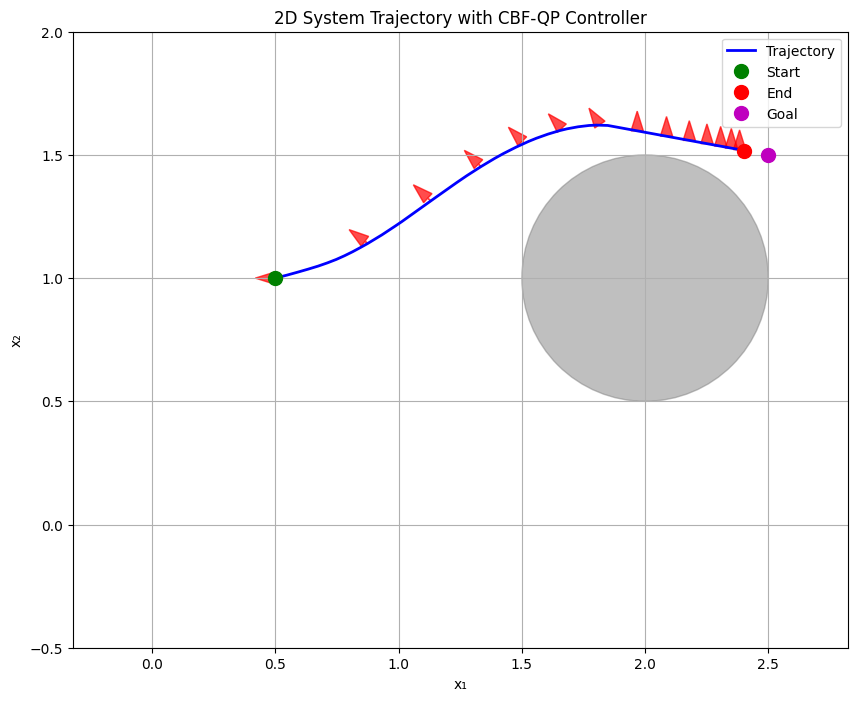

Minimum CBF value along trajectory: 0.08207488059997559
CBF violated? No


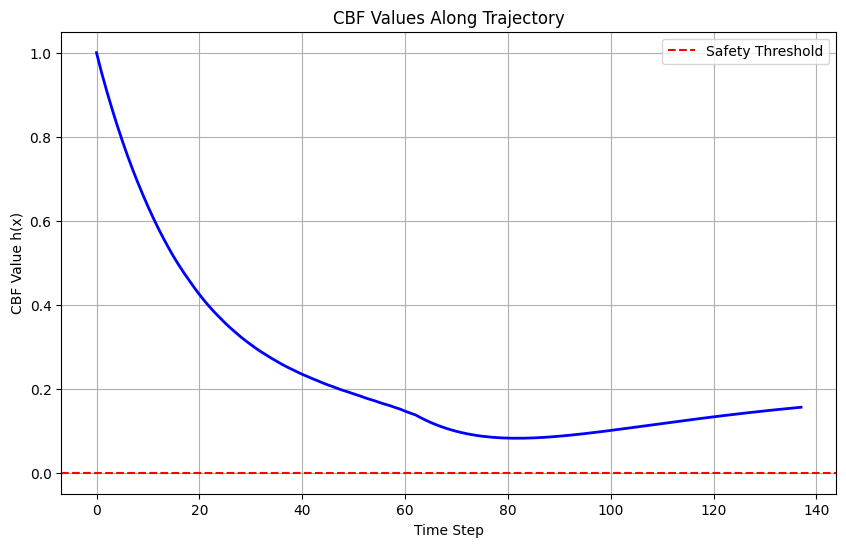

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Plot trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')
plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=10, label='End')
plt.plot(2.5, 1.5, 'mo', markersize=10, label='Goal')

# Plot obstacle
obstacle_center = jnp.array([2.0, 1.0])
obstacle_radius = 0.5
circle = plt.Circle(
    (obstacle_center[0], obstacle_center[1]), 
    obstacle_radius, 
    fill=True, 
    color='gray', 
    alpha=0.5
)
plt.gca().add_patch(circle)

# Plot control vectors at some points (every 10 steps)
stride = 10
for i in range(0, len(trajectory)-1, stride):
    if i < len(controls):
        plt.arrow(
            trajectory[i, 0], 
            trajectory[i, 1],
            controls[i, 0] * 0.05, 
            controls[i, 1] * 0.05,
            head_width=0.05, 
            head_length=0.08, 
            fc='red', 
            ec='red', 
            alpha=0.7
        )

plt.grid(True)
plt.legend()
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('2D System Trajectory with CBF-QP Controller')
plt.axis('equal')
plt.xlim(-0.5, 3.0)
plt.ylim(-0.5, 2.0)
plt.show()

# Plot CBF values over time
cbf_values = jnp.array([cbf(x) for x in trajectory])
min_cbf = jnp.min(cbf_values)
print(f"Minimum CBF value along trajectory: {min_cbf}")
print(f"CBF violated? {'Yes' if min_cbf < 0 else 'No'}")

plt.figure(figsize=(10, 6))
plt.plot(cbf_values, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', label='Safety Threshold')
plt.grid(True)
plt.xlabel('Time Step')
plt.ylabel('CBF Value h(x)')
plt.title('CBF Values Along Trajectory')
plt.legend()
plt.show()